# NLP: Classify Articles from Titles

We will walk through an end-to-end example of taking the raw text of the articles' titles, clean it, tokenize and vectorize it, explore it, and develop a model to classify each article into one of 4 labeled classes (business, sports, technology, or entertainment). 

In [3]:
import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib default plotting styles
plt.rc("patch", edgecolor="black", force_edgecolor=True)
plt.rc("axes", grid=True)
plt.rc("grid", linestyle=":", linewidth=0.8, alpha=0.7)
plt.rc("axes.spines", right=False, top=False)
plt.rc("figure", figsize=(11, 8))
plt.rc("font", size=12.0)
plt.rc("hist", bins=25)

import acquire

## Acquire: Scrape InShorts.com

Acquire news articles from [InShorts](inshorts.com) using `BeautifulSoup` and `get.requests`

- [business](https://inshorts.com/en/read/business)
- [sports](https://inshorts.com/en/read/sports)
- [technology](https://inshorts.com/en/read/technology)
- [entertainment](https://inshorts.com/en/read/entertainment)

In [4]:
original_df = acquire.get_news_articles()

In [5]:
original_df.head()

,author,body,category,published_date,title
0,Krishna Veera Vanamali,"British cave explorer Vernon Unsworth, who los...",business,2019-12-07T15:31:16.000Z,I'll take it on the chin: Cave explorer after ...
1,Krishna Veera Vanamali,After a US jury found that Elon Musk did not d...,business,2019-12-07T16:34:59.000Z,My faith in humanity is restored: Musk after w...
2,Dharna,A Lucknow-based customer has filed an FIR agai...,business,2019-12-09T08:17:05.000Z,FIR filed against Club Factory in Lucknow for ...
3,Pragya Swastik,Former RBI Governor Raghuram Rajan in an artic...,business,2019-12-08T10:40:17.000Z,Ideas come from a small set of people around P...
4,Krishna Veera Vanamali,Congress leader Shashi Tharoor said he wants a...,business,2019-12-08T01:30:55.000Z,I want a 'New India' where Bajaj can speak fea...


We are only going to work with the article titles in this example. 
We will select title and category (our target variable) and assign those to a new dataframe that we will work with moving forward. 

In [6]:
df = original_df[['title','category']]

In [7]:
df.head()

,title,category
0,I'll take it on the chin: Cave explorer after ...,business
1,My faith in humanity is restored: Musk after w...,business
2,FIR filed against Club Factory in Lucknow for ...,business
3,Ideas come from a small set of people around P...,business
4,I want a 'New India' where Bajaj can speak fea...,business


In [8]:
df.shape

(99, 2)

## Prepare
### Normalize Text

- Convert to all lowercase  
- Normalize the unicode chars  
- Remove any non-alpha or whitespace characters  
- Remove any alpha strings with 2 characters or less  

In [9]:
string = df.title[0]
print(string)
string = string.lower()
print(string)
string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
print(string)

string = re.sub(r'[^a-z]', ' ', string)
print(string)

string = re.sub(r'\b[a-z]{,2}\b', '', string)
print(string)

string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
print(string)

string = re.sub(r'\s+', ' ', string)
print(string)

string = string.strip()
print(string)

I'll take it on the chin: Cave explorer after losing case against Elon Musk
i'll take it on the chin: cave explorer after losing case against elon musk
i'll take it on the chin: cave explorer after losing case against elon musk
i ll take it on the chin  cave explorer after losing case against elon musk
  take   the chin  cave explorer after losing case against elon musk
  take   the chin  cave explorer after losing case against elon musk
 take the chin cave explorer after losing case against elon musk
take the chin cave explorer after losing case against elon musk


In [10]:
def normalize(string):
    """
    Convert to all lowercase  
    Normalize the unicode chars  
    Remove any non-alpha or whitespace characters  
    Remove any alpha strings with 2 characters or less  
    """
    string = string.lower()
    string = unicodedata.normalize('NFKD', string).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # keep only alpha chars
    string = re.sub(r'[^a-z]', ' ', string)
    
    # remove strings less than 2 chars in length
    string = re.sub(r'\b[a-z]{,2}\b', '', string)
    
    # convert newlines and tabs to a single space
    string = re.sub(r'[\r|\n|\r\n]+', ' ', string)
    
    # strip extra whitespace
    string = string.strip()
    
    return string

df = df.assign(normalized = df.title.apply(normalize))

In [11]:
df.head()

,title,category,normalized
0,I'll take it on the chin: Cave explorer after ...,business,take the chin cave explorer after losing ca...
1,My faith in humanity is restored: Musk after w...,business,faith humanity restored musk after winning ...
2,FIR filed against Club Factory in Lucknow for ...,business,fir filed against club factory lucknow for se...
3,Ideas come from a small set of people around P...,business,ideas come from small set people around ra...
4,I want a 'New India' where Bajaj can speak fea...,business,want new india where bajaj can speak fearle...


### Stem

In [12]:
print(string)

ps = nltk.porter.PorterStemmer()
stems = [ps.stem(word) for word in string.split()]
stem_string = ' '.join(stems)

take the chin cave explorer after losing case against elon musk


In [13]:
def stem(string):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in string.split()]
    string_of_stems = ' '.join(stems)
    return string_of_stems

### Lemmatize

In [14]:
print(string)
wnl = nltk.stem.WordNetLemmatizer()
lemmas = [wnl.lemmatize(word) for word in string.split()]
lemma_string = ' '.join(lemmas)
print(lemma_string)
print(stem_string)

take the chin cave explorer after losing case against elon musk
take the chin cave explorer after losing case against elon musk
take the chin cave explor after lose case against elon musk


In [15]:
def lemmatize(string):
    wnl = nltk.stem.WordNetLemmatizer()
    lemmas = [wnl.lemmatize(word) for word in string.split()]
    string_of_lemmas = ' '.join(lemmas)
    return string_of_lemmas

### Tokenize

In [16]:
print(string)
tokenizer = nltk.tokenize.ToktokTokenizer()
tokenized_string = tokenizer.tokenize(string, return_str=True)

take the chin cave explorer after losing case against elon musk


In [17]:
def tokenize(string):
    tokenizer = nltk.tokenize.ToktokTokenizer()
    return tokenizer.tokenize(string, return_str=True)

### Remove Stopwords

In [18]:
words = tokenized_string.split()
print(words)
stopwords_list = stopwords.words('english')
exclude_words = ['me']
stopwords_list = set(stopwords_list) - set(exclude_words)
include_words = ['Dom']
stopwords_list = stopwords_list.union(set(include_words))
filtered_words = [w for w in words if w not in stopwords_list]
filtered_words = ' '.join(filtered_words)
filtered_words

['take', 'the', 'chin', 'cave', 'explorer', 'after', 'losing', 'case', 'against', 'elon', 'musk']


'take chin cave explorer losing case elon musk'

In [19]:
def remove_stopwords(tokenized_string, extra_words=[], exclude_words=[]):
    words = tokenized_string.split()
    stopword_list = stopwords.words('english')

    # remove the excluded words from the stopword list
    stopword_list = set(stopword_list) - set(exclude_words)

    # add in the user specified extra words
    stopword_list = stopword_list.union(set(extra_words))

    filtered_words = [w for w in words if w not in stopword_list]
    final_string = " ".join(filtered_words)
    return final_string

### Prep Summary

In [20]:
df = original_df[['title','category']]
df.head()

,title,category
0,I'll take it on the chin: Cave explorer after ...,business
1,My faith in humanity is restored: Musk after w...,business
2,FIR filed against Club Factory in Lucknow for ...,business
3,Ideas come from a small set of people around P...,business
4,I want a 'New India' where Bajaj can speak fea...,business


In [21]:
df = original_df[['title','category']]
df = df.assign(original = df.title)

df = df.assign(normalized = df.original.apply(normalize))

df = df.assign(stemmed = df.normalized.apply(stem))
df = df.assign(lemmatized = df.normalized.apply(lemmatize))

df = df.assign(cleaned = df.stemmed.apply(remove_stopwords))
df.head()

,title,category,original,normalized,stemmed,lemmatized,cleaned
0,I'll take it on the chin: Cave explorer after ...,business,I'll take it on the chin: Cave explorer after ...,take the chin cave explorer after losing ca...,take the chin cave explor after lose case agai...,take the chin cave explorer after losing case ...,take chin cave explor lose case elon musk
1,My faith in humanity is restored: Musk after w...,business,My faith in humanity is restored: Musk after w...,faith humanity restored musk after winning ...,faith human restor musk after win defam case,faith humanity restored musk after winning def...,faith human restor musk win defam case
2,FIR filed against Club Factory in Lucknow for ...,business,FIR filed against Club Factory in Lucknow for ...,fir filed against club factory lucknow for se...,fir file against club factori lucknow for sell...,fir filed against club factory lucknow for sel...,fir file club factori lucknow sell fake item
3,Ideas come from a small set of people around P...,business,Ideas come from a small set of people around P...,ideas come from small set people around ra...,idea come from small set peopl around rajan ec...,idea come from small set people around rajan e...,idea come small set peopl around rajan econom ...
4,I want a 'New India' where Bajaj can speak fea...,business,I want a 'New India' where Bajaj can speak fea...,want new india where bajaj can speak fearle...,want new india where bajaj can speak fearlessl...,want new india where bajaj can speak fearlessl...,want new india bajaj speak fearlessli govt tha...


In [22]:
def prep_articles(df):
    df = df.assign(original = df.title)
    df = df.assign(normalized = df.original.apply(normalize))
    df = df.assign(stemmed = df.normalized.apply(stem))
    df = df.assign(lemmatized = df.normalized.apply(lemmatize))
    df = df.assign(cleaned = df.stemmed.apply(remove_stopwords))
    df.drop(columns=["title"], inplace=True)
    return df

### Wrangle Summary (Acquire + Prep)

1. acquire data via web scraping  
2. select the column of text to be used as features and the target variable  
3. prepare the text  
    - normalize the text  
    - lemmatize the normalized text  
    - remove stopwords from the lemmatized text  
    

In [23]:
def prep_news_articles(text, target):
    df = acquire.get_news_articles()
    df = df[[text, target]]
    df = prep_articles(df)
    return df

In [24]:
df = prep_news_articles('title','category')

In [25]:
df = df[['category','cleaned']]

df.head()

,category,cleaned
0,business,take chin cave explor lose case elon musk
1,business,faith human restor musk win defam case
2,business,fir file club factori lucknow sell fake item
3,business,idea come small set peopl around rajan econom ...
4,business,want new india bajaj speak fearlessli govt tha...


## Explore & Define Features

We will do a very quick exploration, due to time, which will naturally blend into feature engineering.  

### Category Distribution

In [26]:
df.category.value_counts(normalize=True)

entertainment    0.252525
sports           0.252525
technology       0.252525
business         0.242424
Name: category, dtype: float64

In [27]:
pd.concat(
    [df.category.value_counts(), df.category.value_counts(normalize=True)], axis=1
).set_axis(["n", "percent"], axis=1, inplace=False)

,n,percent
entertainment,25,0.252525
sports,25,0.252525
technology,25,0.252525
business,24,0.242424


### Term Frequency

Generally, when you hear 'Term Frequency', it is referring to the number of documents in which a word appears.  
*When we move on to computing TF-IDF, this basic definition of Term Frequency applies*.  

However, term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.  

- **Raw Count**: This is simply the count of the number of occurances of each word.
- **Frequency**: The number of times each word appears divided by the total number of words.
- **Augmented Frequency**: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

In [28]:
# raw_count = pd.Series(' '.join(df[df.category=='business']['cleaned']).split()).value_counts()

In [29]:
raw_count = pd.Series(" ".join(df.cleaned).split()).value_counts()

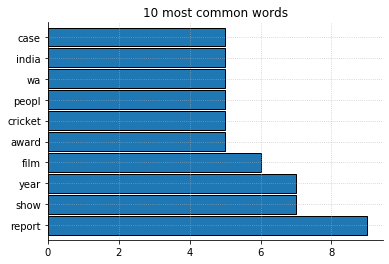

In [30]:
raw_count.sort_values(ascending=False)[0:10].plot.barh(width=.9)
plt.title('10 most common words')

plt.show()

In [31]:
# type(raw_count)

tf_df = pd.DataFrame({'raw_count': raw_count})

tf_df = tf_df.assign(frequency = lambda df: df.raw_count / df.raw_count.sum())

tf_df = tf_df.assign(augmented_frequency = lambda df: df.frequency / df.frequency.max())

tf_df.frequency.max()

tf_df.head()

,raw_count,frequency,augmented_frequency
report,9,0.011628,1.000000
show,7,0.009044,0.777778
year,7,0.009044,0.777778
film,6,0.007752,0.666667
award,5,0.006460,0.555556


In [32]:
tf_df = (pd.DataFrame({'raw_count': raw_count})
         .assign(frequency=lambda df: df.raw_count / df.raw_count.sum())
         .assign(augmented_frequency=lambda df: df.frequency / df.frequency.max()))

tf_df.head(6)

,raw_count,frequency,augmented_frequency
report,9,0.011628,1.000000
show,7,0.009044,0.777778
year,7,0.009044,0.777778
film,6,0.007752,0.666667
award,5,0.006460,0.555556
cricket,5,0.006460,0.555556


### Inverse Document Frequency (IDF)

Inverse Document Frequency also provides information about individual words, but, in order to use this measure, we must have multiple documents, i.e. several different bodies of text.

- provides information about individual words in a document with respect the those words' frequency across the corpus, which must include multiple documents.  
- indicates how valuable a word is in terms of the information it provides.
- The more frequently a word appears in the corpus, the less information it provides when found in a certain document. This will lead to a lower IDF score. 
- Lower IDF $\rightarrow$ less important when found in a document, i.e. that word gives us less information about the document than a word with a high IDF. 
- Example: 'the' would have a *very* low IDF which indicates we learn very little about an individual document knowing that the word 'the' appears in it.  

$$
\mbox{idf}(\mbox{word})
=
\log\left(\frac{\mbox{# of documents}}{\mbox{# of documents containing the word + 1}}\right)
$$

Notes on IDF calculation

- If a given word doesn't appear in any documents, the denominator in the equation above would be zero, so it is best to add 1 to the denominator, as indicated above.   
- The denominator is *NOT* necessarily equivalent to Term Frequency, which is the total number of times the word appears in a corpus. When a word appears in a document more than once, these numbers will differ. 
    


For example, imagine we have 20 documents. We can visualize what the idf score looks like with the code below:

Text(0.5, 1.0, 'IDF for a given word')

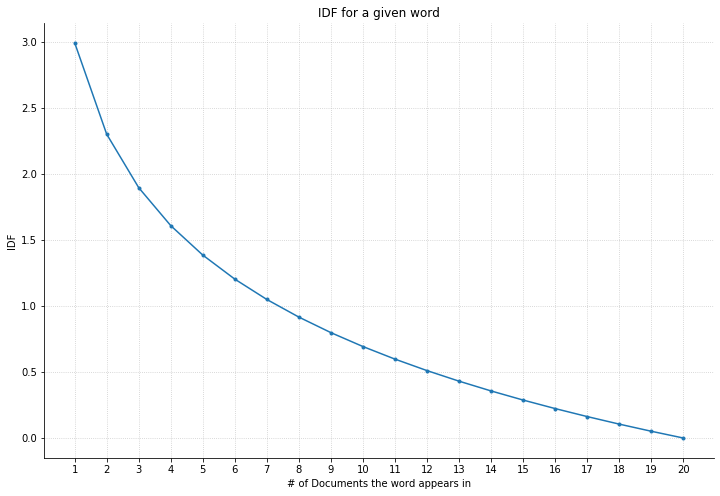

In [33]:
n_documents = 20

x_denominator = np.arange(1, n_documents + 1)
y_idf = np.log(n_documents / x_denominator)

plt.figure(figsize=(12, 8))
plt.plot(x_denominator, y_idf, marker='.')

plt.xticks(x_denominator)
plt.xlabel('# of Documents the word appears in')
plt.ylabel('IDF')
plt.title('IDF for a given word')

Compute IDF for the titles of the news ariticles. We need:  

- number of occurrences of the word (denominator)   
- total number of documents (numerator) 

First, let's compute IDF for a single word to see how it's done.  

In [34]:
print("word: india")
denom = sum([1 for doc in df.cleaned if 'india' in doc])
print("# of occurrences: ", denom)
num = len(df.cleaned)
print("# of documents: ", num)
idf = np.log(num/(denom+1))
print("idf = ", idf)

word: india
# of occurrences:  5
# of documents:  99
idf =  2.803360380906535


Write the IDF function

In [35]:
def idf(word):
    n_occurrences = sum([1 for doc in df.cleaned if word in doc])
    n_docs = len(df.cleaned)
    idf = np.log(n_docs/n_occurrences)
    return idf

Now, we need to do it for all words in our corpus. To do that, we need:  

- list of unique words  
- assign words to a dataframe  
- calculate the idf for each word  

#### Unique Words

- join all docs together into corpus as single document
- split corpus into single words & convert to list of words
- keep only a single, unique value for each word. (dedup)


In [36]:
part1 = ' '.join(df.cleaned)
part2 = part1.split()
part3 = pd.Series(part2)
# print(part3.value_counts())

part4 = part3.unique()
type(part4)
# confirm that those words that existed multiple times, are now only represented once in the unique_words list. 
# print(pd.Series(part4).value_counts())

numpy.ndarray

In [37]:
unique_words = pd.Series(' '.join(df.cleaned).split()).unique()

- add to a dataframe
- apply idf() to compute IDF for each unique word
- sort idf_df for quick peeks into the results

In [38]:
word_df = pd.DataFrame(dict(word = unique_words))
word_df.head()

word_df = word_df.assign(idf = lambda df: df.word.apply(idf))

word_df.set_index('word').sort_values(by='idf', ascending = False).head(5)

,idf
word,
dedic,4.59512
line,4.59512
joshua,4.59512
headach,4.59512
facil,4.59512


In [39]:
# put in a dataframe
idf_df = pd.DataFrame(dict(word = unique_words))\
    .assign(idf = lambda df: df.word.apply(idf))\
    .set_index('word').sort_values(by='idf', ascending = False)

idf_df.head(5)

,idf
word,
dedic,4.59512
line,4.59512
joshua,4.59512
headach,4.59512
facil,4.59512


### TF-IDF

In [40]:
documents = df.cleaned.to_dict()
# documents

text = df.cleaned[0]

pd.Series(text.split()).value_counts()\
    .reset_index()\
    .set_axis(['word','raw_count'], axis=1, inplace=False)\
    .assign(tf = lambda df: df.raw_count / df.shape[0])\
    .drop(columns=['raw_count'])\
    .assign(doc=0)

,word,tf,doc
0,chin,0.125,0
1,musk,0.125,0
2,cave,0.125,0
3,explor,0.125,0
4,case,0.125,0
5,lose,0.125,0
6,elon,0.125,0
7,take,0.125,0


In [41]:
# We'll caclulate the tf-idf value for every word across every document
tfs = []

# Start by iterating over all the documents
for doc, text in documents.items():
    # We'll make a data frame that contains the tf for every word in every document
    tf_df = (pd.Series(text.split())
          .value_counts()
          .reset_index()
          .set_axis(['word', 'raw_count'], axis=1, inplace=False)
          .assign(tf=lambda df: df.raw_count / df.shape[0])
          .drop(columns='raw_count')
          .assign(doc=doc))
    # Then add that data frame to our list
    tfs.append(tf_df)

In [42]:
tfs[0:2]

[     word     tf  doc
 0    chin  0.125    0
 1    musk  0.125    0
 2    cave  0.125    0
 3  explor  0.125    0
 4    case  0.125    0
 5    lose  0.125    0
 6    elon  0.125    0
 7    take  0.125    0,      word        tf  doc
 0    musk  0.142857    1
 1   human  0.142857    1
 2  restor  0.142857    1
 3    case  0.142857    1
 4   defam  0.142857    1
 5   faith  0.142857    1
 6     win  0.142857    1]

In [43]:
tfidf_df = pd.concat(tfs)\
            .assign(idf = lambda tf_df: tf_df.word.apply(idf))\
            .assign(tf_idf = lambda tf_df: tf_df.idf * tf_df.tf)\
            .drop(columns=['tf', 'idf'])\
            .sort_values(by='tf_idf', ascending=False)

In [44]:
tfidf_df.head()

,word,doc,tf_idf
0,call,54,1.312891
0,airport,5,1.312891
0,iphon,58,1.300658
0,walsh,30,1.148780
0,miss,77,1.114849


### TF-IDF with Scikit-Learn

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(documents.values())

This returns a sparse matrix:  
- a matrix with more 0s than anything else. 
- Numpy has a special type that makes some manipulations and operations faster on sparse matrices.

Becuase our data set is pretty small, we can convert our sparse matrix to a regular one, aka 'dense matrix', and put everything in a dataframe. If our data were larger, the operation below might take much longer.

In [46]:
features_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
features_df.head()

,aaryan,ab,abl,account,across,actor,actress,adventur,age,agre,...,whatsapp,win,without,worth,wrongli,ye,year,zero,zilingo,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.33934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Modeling

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv('./spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dt = DecisionTreeClassifier(criterion='entropy', splitter='best',
                           max_depth=None, min_samples_split=8,
                           min_samples_leaf=4,
                           random_state=123).fit(X_train, y_train)

train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

In [48]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 98.38%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3835    48
spam         24   550
---
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      3859
        spam       0.96      0.92      0.94       598

    accuracy                           0.98      4457
   macro avg       0.97      0.96      0.96      4457
weighted avg       0.98      0.98      0.98      4457



In [50]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 96.05%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        948    26
spam        18   123
---
              precision    recall  f1-score   support

         ham       0.97      0.98      0.98       966
        spam       0.87      0.83      0.85       149

    accuracy                           0.96      1115
   macro avg       0.92      0.90      0.91      1115
weighted avg       0.96      0.96      0.96      1115



# Notes

### Feature Extraction: TF-IDF

TF: Term Frequency; how often a word appears in a document.


IDF: Inverse Documnet Frequency; a measure based on in how many documents will a word appear.


TF-IDF: A combination of the two measures above.

### Term Frequency (TF)

Term frequency can be calculated in a number of ways, all of which reflect how frequently a word appears in a document.


Raw Count: This is simply the count of the number of occurances of each word.
Frequency: The number of times each word appears divided by the total number of words.


Augmented Frequency: The frequency of each word divided by the maximum frequency. This can help prevent bias towards larger documents.

### Modeling

Now we'll use the computed TF-IDF values as features in a model. We'll take a look at the spam data set first.


Because of the way we are modeling the data, we have a lot of columns, and it is not uncommon to have more columns than rows. Also, our data is very imbalanced in the class distribution, that is, there are many more ham messages than spam messages.


Other than these considerations, we can treat this as a standard classification problem. We'll use logistic regression as an example:



# Exercises

- What other types of models (i.e. different classifcation algorithms) could you use?


- How do the models prepare when trained on term frequency data alone, instead of TF-IDF values?

## Logistic Regression Model

In [51]:
df = pd.read_csv('spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Evaluate Train Set

In [63]:
print('Logistic Regression Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Logistic Regression Train Accuracy: 97.96%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3834    66
spam         25   532
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      3859
        spam       0.96      0.89      0.92       598

    accuracy                           0.98      4457
   macro avg       0.97      0.94      0.95      4457
weighted avg       0.98      0.98      0.98      4457



## Evaluate Test Set

In [64]:
print('Logistic Regression Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Logistic Regression Test Accuracy: 97.94%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        961    18
spam         5   131
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



## Decision Tree Model

In [54]:
df = pd.read_csv('./spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

dt = DecisionTreeClassifier(criterion='entropy', splitter='best',
                           max_depth=None, min_samples_split=8,
                           min_samples_leaf=4,
                           random_state=123).fit(X_train, y_train)

train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

## Evaluate Train Set

In [65]:
print('Decision Tree Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Decision Tree Train Accuracy: 97.96%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3834    66
spam         25   532
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      3859
        spam       0.96      0.89      0.92       598

    accuracy                           0.98      4457
   macro avg       0.97      0.94      0.95      4457
weighted avg       0.98      0.98      0.98      4457



## Evaluate Test Set

In [66]:
print('Decision Tree Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Decision Tree Test Accuracy: 97.94%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        961    18
spam         5   131
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115



# K-Nearest Neighbors Model

In [57]:
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('./spam_clean.csv')
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.text)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform').fit(X_train, y_train)

train['predicted'] = dt.predict(X_train)
test['predicted'] = dt.predict(X_test)

In [67]:
print('K-NN Train Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

K-NN Train Accuracy: 97.96%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3834    66
spam         25   532
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99      3859
        spam       0.96      0.89      0.92       598

    accuracy                           0.98      4457
   macro avg       0.97      0.94      0.95      4457
weighted avg       0.98      0.98      0.98      4457



In [68]:
print('K-NN Test Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

K-NN Test Accuracy: 97.94%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        961    18
spam         5   131
---
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.88      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115

